In [1]:
from CosinorPy import file_parser, cosinor, cosinor1, cosinor_nonlin
import numpy as np
import pandas as pd
import os

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams.update({'font.size': 14})

## General settings

In [3]:
csv_folder = ""

In [4]:
#N=100
#prefix="02_"
#df_results_all = pd.read_csv(os.path.join(csv_folder,f'{prefix}evalutation_results_{N}.csv'))
#df_results_all.to_csv(os.path.join("supp_tables2","supp_table_7.csv"), index=False)
df_results_all = pd.read_csv(os.path.join('supp_tables2','supp_table_7.csv'))

In [5]:
#df_results_all = df_results_all[df_results_all['test(noise)']<1]

In [6]:
NOISE = df_results_all['test(noise)'].unique()
N_COMPONENTS = df_results_all['test(n_components)'].unique()
LIN_COMP = df_results_all['test(lin_comp)'].unique()
AMPLIFICATION = df_results_all['test(amplification)'].unique()

Absolute errors

In [7]:
df_results_all['d_amplitude'] = np.abs(df_results_all['amplitude'] - df_results_all['amplitude0'])

df_results_all['d_acrophase'] = np.abs(df_results_all['acrophase'] - df_results_all['acrophase0'])
df_results_all['d_acrophase'] = np.abs(df_results_all['d_acrophase'].map(cosinor.project_acr))

df_results_all['d_amplification'] = np.abs(df_results_all['amplification'] - df_results_all['amplification0'])

df_results_all['d_lin_comp'] = np.abs(df_results_all['lin_comp'] - df_results_all['lin_comp0'])                       

Model labels

In [8]:
model_label = []

for n_comps, gen in zip(df_results_all['n_components'], df_results_all['gen']):
    if gen:
        #model_label.append('cosinor' + str(int(n_comps)) + " gen.")
        model_label.append('C' + str(int(n_comps)) + "G")
    else:
        #model_label.append('cosinor' + str(int(n_comps)))
        model_label.append('C' + str(int(n_comps)))

df_results_all['model'] = model_label

Dataset labels

In [9]:
dataset_label = []
for lin_comp, amplif, n_comps in zip(df_results_all['test(lin_comp)'], df_results_all['test(amplification)'], df_results_all['test(n_components)']):
    #if lin_comp or amplif:
    #    dataset_label.append(str(int(n_comps)) + ' comp., gen.')
    osc_type = 'S' if n_comps == 1 else 'A'    
    amplif_type = 'F' if amplif > 0 else 'D' if amplif < 0 else ''
    #if amplif > 0:
    #    dataset_label.append(str(int(n_comps)) + ' comp., F.')
    #elif amplif < 0:
    #    dataset_label.append(str(int(n_comps)) + ' comp., D.')
    #else:
    #    dataset_label.append(str(int(n_comps)) + ' comp.')
    dataset_label.append(osc_type+amplif_type)
    
df_results_all['dataset'] = dataset_label

## Statistics

In [10]:
df_stats = pd.DataFrame()
tests_all = df_results_all

for noise in NOISE:    
    for n_components in N_COMPONENTS:               
        for lin_comp in LIN_COMP:                
            for amplification in AMPLIFICATION:                    
                cond = (tests_all['test(noise)'] == noise) & (tests_all['test(lin_comp)'] == lin_comp) & (tests_all['test(amplification)'] == amplification) & (tests_all['test(n_components)'] == n_components)

                d = {'test(noise)':noise,
                     'test(lin_comp)':lin_comp,
                     'test(amplification)': amplification,
                     'test(n_components)': n_components}

                df_res = tests_all[cond]
                for n_comps_model in [1,3]:
                    for generalised_model in [0,1]:
                        label = f"model{n_comps_model}"
                        if generalised_model == 1:
                            label += "_gen" 

                        cond2 = (df_res['n_components'] == n_comps_model) & (df_res['gen'] == generalised_model)

                        df_res_model = df_res[cond2]
                        n_models = len(df_res_model)

                        d_amplitude = df_res_model['d_amplitude']
                        d_acrophase = df_res_model['d_acrophase']
                        d_amplification = df_res_model['d_amplification']
                        d_lin_comp = df_res_model['d_lin_comp']

                        d[f'MSE_amplitude({label})'] = np.nansum(d_amplitude**2)/len(d_amplitude)
                        d[f'MSE_acrophase({label})'] = np.nansum(d_acrophase**2)/len(d_acrophase)
                        #d[f'MSE_amplification({label})'] = np.nansum(d_amplification**2)/len(d_amplification)
                        #d[f'MSE_lin_comp({label})'] = np.nansum(d_lin_comp**2)/len(d_lin_comp)

                df_stats = df_stats.append(d, ignore_index=True)        



Amplification labels

In [11]:
amplification_label = []
for amplif in df_stats['test(amplification)']:
    if amplif > 0:
        amplification_label.append('forced')
    elif amplif < 0:
        amplification_label.append('damped')
    else:
        amplification_label.append('none')

df_stats['amplification type'] = amplification_label

Oscillation labels

In [12]:
oscillation_label = []
for n_comps in df_stats['test(n_components)']:
    if n_comps > 1:
        oscillation_label.append('asymmetric')
    else:
        oscillation_label.append('symmetric')
    
df_stats['oscillation type'] = oscillation_label

In [13]:
#order={'symmetric':0, 'asymmetric':1}

### Summary of amplitude errors

In [14]:
df_stats_summary_amplitudes = df_stats[['oscillation type', 'amplification type', 'test(noise)','MSE_amplitude(model1)','MSE_amplitude(model1_gen)','MSE_amplitude(model3)','MSE_amplitude(model3_gen)']]
df_stats_summary_amplitudes.columns = ['oscillation type', 'amplification type', 'noise', 'C1', 'C1G', 'C3', 'C3G']
df_stats_summary_amplitudes = df_stats_summary_amplitudes.sort_values(by=['oscillation type', 'amplification type', 'noise'])#, key=lambda x:order[x])
df_stats_summary_amplitudes = df_stats_summary_amplitudes.round(3)
f = open(os.path.join(csv_folder,'table_amplitude_errors.txt'), 'w')
f.write(df_stats_summary_amplitudes.to_latex(index=False))
f.close()
df_stats_summary_amplitudes


,oscillation type,amplification type,noise,C1,C1G,C3,C3G
5,asymmetric,damped,0.1,0.876,0.105,0.752,0.011
11,asymmetric,damped,0.2,0.875,0.099,0.742,0.041
17,asymmetric,damped,0.5,0.874,0.371,0.652,1.704
23,asymmetric,damped,1.0,0.753,1.140,0.414,8.885
4,asymmetric,forced,0.1,81.771,0.234,127.804,0.008
10,asymmetric,forced,0.2,79.448,0.225,126.010,0.035
16,asymmetric,forced,0.5,80.331,0.385,136.439,0.154
22,asymmetric,forced,1.0,77.913,0.722,142.018,0.690
3,asymmetric,none,0.1,0.051,0.057,0.001,0.002
9,asymmetric,none,0.2,0.074,0.081,0.003,0.012


### Summary of acrophase errors

In [15]:
df_stats_summary_acrophases = df_stats[['oscillation type', 'amplification type', 'test(noise)','MSE_acrophase(model1)','MSE_acrophase(model1_gen)','MSE_acrophase(model3)','MSE_acrophase(model3_gen)']]
df_stats_summary_acrophases.columns = ['oscillation type', 'amplification type', 'noise', 'C1', 'C1G', 'C3', 'C3G']
df_stats_summary_acrophases = df_stats_summary_acrophases.sort_values(by=['oscillation type', 'amplification type', 'noise'])#, key=lambda x:order[x])
df_stats_summary_acrophases = df_stats_summary_acrophases.round(3)
f = open(os.path.join(csv_folder,'table_acrophase_errors.txt'), 'w')
f.write(df_stats_summary_acrophases.to_latex(index=False))
f.close()
df_stats_summary_acrophases

,oscillation type,amplification type,noise,C1,C1G,C3,C3G
5,asymmetric,damped,0.1,0.209,0.215,0.277,0.088
11,asymmetric,damped,0.2,0.252,0.257,0.204,0.220
17,asymmetric,damped,0.5,0.240,0.258,0.386,0.579
23,asymmetric,damped,1.0,0.582,0.549,1.055,1.071
4,asymmetric,forced,0.1,0.214,0.209,0.320,0.043
10,asymmetric,forced,0.2,0.200,0.211,0.253,0.032
16,asymmetric,forced,0.5,0.223,0.241,0.283,0.208
22,asymmetric,forced,1.0,0.241,0.265,0.324,0.541
3,asymmetric,none,0.1,0.227,0.228,0.043,0.042
9,asymmetric,none,0.2,0.274,0.275,0.122,0.154


## Plots

https://seaborn.pydata.org/generated/seaborn.violinplot.html

### Amplitudes

In [16]:
dataset_full = {'A': 'asymmetric',
                'S': 'symmetric',
                'AF': 'asymmetric forced',
                'SF': 'symmetric forced',
                'AD': 'asymmetric damped',
                'SD': 'symmetric damped'}

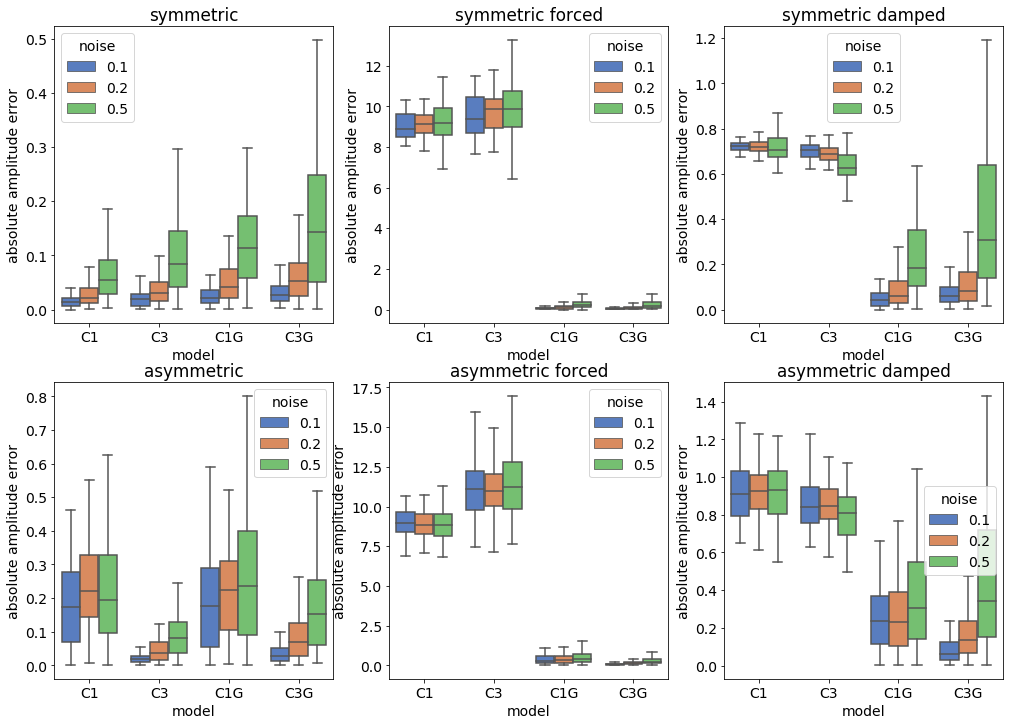

In [17]:
fig, axes = plt.subplots(2,3)
box = 1

for i, (dataset) in enumerate(df_results_all['dataset'].unique()):
    data = df_results_all[df_results_all['dataset']==dataset]
    data = data[data['test(noise)']<1] 
    data = data.rename(columns={'test(noise)':'noise'})
    
    #data = data[data['dataset'] != 'AF']
    #data = data[data['dataset'] != 'SF']
        
    ax = axes.flat[i]
    if box:
        sns.boxplot(x='model', y='d_amplitude', hue='noise', data=data, palette="muted", showfliers = False, ax=ax) # , order=["Dinner", "Lunch"]
    else:    
        sns.violinplot(x='model', y='d_amplitude', hue='noise', data=data, palette="muted", cut=0, ax=ax) # , order=["Dinner", "Lunch"]

    ax.set_ylabel("absolute amplitude error")
    ax.set_ylabel("absolute amplitude error")
    ax.title.set_text(dataset_full[dataset])

    
fig=plt.gcf()

fig.set_size_inches([17,12])
plt.savefig(os.path.join(csv_folder,'amplitude_errors.pdf'), bbox_inches = 'tight')
plt.show()

### Acrophases

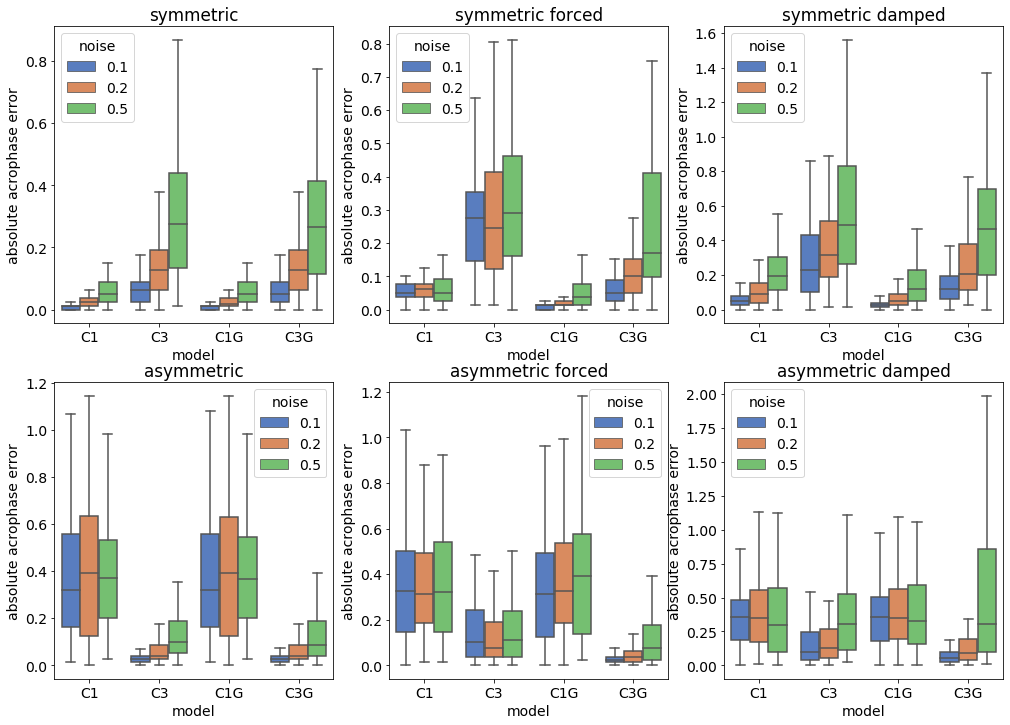

In [18]:
fig, axes = plt.subplots(2,3)
box = 1

for i, (dataset) in enumerate(df_results_all['dataset'].unique()):
    data = df_results_all[df_results_all['dataset']==dataset]
    data = data[data['test(noise)']<1]    
    #data = data[data['dataset'] != 'AF']
    #data = data[data['dataset'] != 'SF']
    
    data = data.rename(columns={'test(noise)':'noise'})
        
    ax = axes.flat[i]
    if box:
        sns.boxplot(x='model', y='d_acrophase', hue='noise', data=data, palette="muted", showfliers = False, ax=ax) # , order=["Dinner", "Lunch"]
    else:    
        sns.violinplot(x='model', y='d_acrophase', hue='noise', data=data, palette="muted", cut=0, ax=ax) # , order=["Dinner", "Lunch"]

    ax.set_ylabel("absolute acrophase error")
    ax.set_ylabel("absolute acrophase error")
    ax.title.set_text(dataset_full[dataset])

    
fig=plt.gcf()

fig.set_size_inches([17,12])
plt.savefig(os.path.join(csv_folder,'acrophase_errors.pdf'), bbox_inches = 'tight')
plt.show()